# Explore PERIMETRO INIZIALE

The file PERIMETRO_INIZIALE.csv is the key file for this data challenge. For this reason it make sense to start the data exploration from here.

The file contains monthly information of NPL customers such as:
* Reference month and year
* Bank brench managing the customer
* Customer ID
* Gross Book Value of the debt
* Monthly recovered amount

This dataset represents the historical information on NPLs in the period of reference.

In this first explorative phase I will try to:
1. Clean the dataset by removing/replacing null values and rejecting invalid rows;
2. Explore the available information and, if necessary, define additional interesting new features;
3. Perfom some analytics to develop intuitions about the data and their meaning;

At the end of the notebook I will summarize any interesting finding and important takeaways;

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os.path as path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

DATA_PATH = 'DATA'

## Open the file and cross-check consistency

In [2]:
df=pd.read_csv(path.join(DATA_PATH, 'PERIMETRO_INIZIALE.csv'), sep=';', decimal=',', low_memory=False)

Dataset shape:

In [3]:
df.shape

(528849, 9)

All dataset columns are read correctly:

In [4]:
df.head()

,NUM_ANNO,NUM_YYYYMM,FILIALE,ID_CUSTOMER,NUM_DATA_SOFFERENZA,IMP_GBV,IMP_INCASSI,IMP_CUSUM_INCASSI,IMP_INCASSI_TOT
0,2015,201511,13721,12519,2003.0,10187.48,0.0,0.0,0.0
1,2015,201512,13721,12519,2003.0,10223.53,0.0,0.0,0.0
2,2016,201601,13721,12519,2003.0,10257.87,0.0,0.0,0.0
3,2016,201602,13721,12519,2003.0,10289.95,0.0,0.0,0.0
4,2016,201603,13721,12519,2003.0,10324.25,0.0,0.0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528849 entries, 0 to 528848
Data columns (total 9 columns):
NUM_ANNO               528849 non-null int64
NUM_YYYYMM             528849 non-null int64
FILIALE                528849 non-null int64
ID_CUSTOMER            528849 non-null int64
NUM_DATA_SOFFERENZA    482751 non-null float64
IMP_GBV                528849 non-null float64
IMP_INCASSI            528849 non-null float64
IMP_CUSUM_INCASSI      528849 non-null float64
IMP_INCASSI_TOT        528849 non-null float64
dtypes: float64(5), int64(4)
memory usage: 36.3 MB


## Check for NAN values

In [6]:
df.isnull().sum(axis = 0)

NUM_ANNO                   0
NUM_YYYYMM                 0
FILIALE                    0
ID_CUSTOMER                0
NUM_DATA_SOFFERENZA    46098
IMP_GBV                    0
IMP_INCASSI                0
IMP_CUSUM_INCASSI          0
IMP_INCASSI_TOT            0
dtype: int64

* The only missing values are found in the 'NUM_DATA_SOFFERENZA' column, which report the first date of credit distress. 
* Given the definition of the column's content, I assume that its value should be unique for each customer. 
* So, if a customer shows a non-null value for this column, the same value is used to fill the NaN (using ffill() & bfill())

In [7]:
df['NUM_DATA_SOFFERENZA'] = df.groupby('ID_CUSTOMER')['NUM_DATA_SOFFERENZA'].transform(lambda x : x.ffill().bfill())

In [8]:
df.isnull().sum(axis = 0)

NUM_ANNO                  0
NUM_YYYYMM                0
FILIALE                   0
ID_CUSTOMER               0
NUM_DATA_SOFFERENZA    2247
IMP_GBV                   0
IMP_INCASSI               0
IMP_CUSUM_INCASSI         0
IMP_INCASSI_TOT           0
dtype: int64

* I recover 43'851 entries with missing 'NUM_DATA_SOFFERENZA' representing 95% of the total
* There are 2'247 rows which remain undefined

Unfortunately there is no way to recover the correct values, or at least there are no further indications in this dataset. Since this feature is used later to define the number of month the NPL is delinquent, entires for which this feature is not defined are discarded.

In [9]:
df.dropna(inplace=True)

Let's check the non null values:

In [10]:
df['NUM_DATA_SOFFERENZA'].value_counts().sort_index()

1010.0        22
1976.0        16
1979.0        24
1982.0        21
1983.0        61
1984.0       109
1985.0       107
1986.0        95
1987.0       424
1988.0       524
1989.0       668
1990.0       669
1991.0       834
1992.0       996
1993.0      1351
1994.0      2172
1995.0      1931
1996.0      1456
1997.0      3047
1998.0      3433
1999.0      3961
2000.0      5320
2001.0      8543
2002.0      7329
2003.0      9433
2004.0     10965
2005.0     15869
2006.0     19016
2007.0     30096
2008.0     39729
2009.0     62072
2010.0     50044
2011.0      8180
2012.0      7821
2013.0     10115
2014.0     16334
2015.0    103805
2016.0     87297
2017.0     12713
Name: NUM_DATA_SOFFERENZA, dtype: int64

* There are 22 entries which shows a column NUM_DATA_SOFFERENZA == 1010;
* This value is not a valid date and cannot be converted as such;

* The 22 entries correspond to 2 CUSTOMER (ID_CUSTOMER 24709 and 23739)
* The entries correspongind to ID_CUSTOMER 24709 and have been reported from 12-2016 to 09-2016
* The entries correspongind to ID_CUSTOMER 23739 and have been reported from 10-2016 to 09-2016

In [11]:
df.loc[df['NUM_DATA_SOFFERENZA']==1010].shape

(22, 9)

In [12]:
df.loc[df['ID_CUSTOMER'].isin([23739,24709])].shape

(22, 9)

In [13]:
df.loc[df['ID_CUSTOMER']==23739, 'NUM_ANNO'][0:1]

383516    2016
Name: NUM_ANNO, dtype: int64

In [14]:
df.loc[df['ID_CUSTOMER']==24709, 'NUM_ANNO'][0:1]

6356    2016
Name: NUM_ANNO, dtype: int64

* The dates for these ID_CUSTOMER are reported within the reference period
* I assume the NUM_DATA_SOFFERENZA should correspond to 2016
* I replace those values with 2016

In [15]:
df.loc[df['NUM_DATA_SOFFERENZA']==1010, 'NUM_DATA_SOFFERENZA'] = 2016

## Convert date in proper datetime

* Convert the columns 'NUM_YYYYMM', 'NUM_ANNO' and 'NUM_DATA_SOFFERENZA' in datetime object
* This allows later to compute difference among dates
* By default dates are converted to the 1st of the month

In [16]:
df['NUM_YYYYMM'] = pd.to_datetime(df['NUM_YYYYMM'], format='%Y%m')
df['NUM_ANNO'] = pd.to_datetime(df['NUM_ANNO'].astype('int64'), format='%Y', errors='coerce')
df['NUM_DATA_SOFFERENZA'] = pd.to_datetime(df['NUM_DATA_SOFFERENZA'].astype('int64'), format='%Y', errors='coerce')

In [17]:
df.head()

,NUM_ANNO,NUM_YYYYMM,FILIALE,ID_CUSTOMER,NUM_DATA_SOFFERENZA,IMP_GBV,IMP_INCASSI,IMP_CUSUM_INCASSI,IMP_INCASSI_TOT
0,2015-01-01,2015-11-01,13721,12519,2003-01-01,10187.48,0.0,0.0,0.0
1,2015-01-01,2015-12-01,13721,12519,2003-01-01,10223.53,0.0,0.0,0.0
2,2016-01-01,2016-01-01,13721,12519,2003-01-01,10257.87,0.0,0.0,0.0
3,2016-01-01,2016-02-01,13721,12519,2003-01-01,10289.95,0.0,0.0,0.0
4,2016-01-01,2016-03-01,13721,12519,2003-01-01,10324.25,0.0,0.0,0.0


No more NaN in the dataset!

In [18]:
df.isnull().sum(axis = 0)

NUM_ANNO               0
NUM_YYYYMM             0
FILIALE                0
ID_CUSTOMER            0
NUM_DATA_SOFFERENZA    0
IMP_GBV                0
IMP_INCASSI            0
IMP_CUSUM_INCASSI      0
IMP_INCASSI_TOT        0
dtype: int64

## Dataset overview

In [19]:
print('Reference period from %s, to %s' % (
    df['NUM_YYYYMM'].min().strftime(format='%m/%Y'),
    df['NUM_YYYYMM'].max().strftime(format='%m/%Y')
))

Reference period from 01/2015, to 09/2017


In [20]:
print('Number of NPL cusotmer in the reference period: %d' % df['ID_CUSTOMER'].unique().shape)

Number of NPL cusotmer in the reference period: 27888


In [21]:
print('Number of bank branches reporting NPL clients %d' % df['FILIALE'].unique().shape)

Number of bank branches reporting NPL clients 3


Overall statistics on IMP_* features.

In [22]:
cols=['IMP_GBV','IMP_INCASSI','IMP_CUSUM_INCASSI']
df[cols].describe()

,IMP_GBV,IMP_INCASSI,IMP_CUSUM_INCASSI
count,526602.000000,526602.000000,526602.000000
mean,4919.219817,18.268581,144.073957
std,4345.697391,293.796584,847.430610
min,0.000000,-7494.490000,-215.610000
25%,1041.952500,0.000000,0.000000
50%,3808.220000,0.000000,0.000000
75%,8268.737500,0.000000,0.000000
max,287192.940000,20438.940000,25723.860000


## Negative values on IMP_INCASSI and IMP_CUSUM_INCASSI

* IMP_INCASSI column shows negative values on 59 rows
* IMP_CUSUM_INCASSI column shows negative values on 92 rows which results from the cumulative sum over the IMP_INCASSI column.

Even though negative values on those columns seem strange, they could correspond to movements from the bank back to the clients or some other internal process of the bank. It does not seems to be a problem to manage these negative values for the rest of the analysis.

In [23]:
df.loc[df['IMP_INCASSI'] <0].shape

(59, 9)

In [24]:
df.loc[df['IMP_CUSUM_INCASSI'] <0].shape

(92, 9)

## Define the total recovery rate

* I define the total recovery rate of the NPL as the fraction of debt being repaied with respect to the maximum amount of debt. 
* The recovery rate is calculated monthly, but always referring to the maximum amount of the debt.

In [25]:
%%time
df['MAX_IMP_GBV'] = df.groupby(['ID_CUSTOMER'])['IMP_GBV'].transform(lambda x: x.max())
# Fraction of INCASSI w.r.t GBV (recovery rate)
df['RECOVERY_RATE_TOTAL'] = df['IMP_CUSUM_INCASSI'] / df['MAX_IMP_GBV']

CPU times: user 7.66 s, sys: 164 ms, total: 7.82 s
Wall time: 8.73 s


In [26]:
# The result of a division might be np.nan or np.inf
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [27]:
df.isnull().sum(axis = 0)

NUM_ANNO                 0
NUM_YYYYMM               0
FILIALE                  0
ID_CUSTOMER              0
NUM_DATA_SOFFERENZA      0
IMP_GBV                  0
IMP_INCASSI              0
IMP_CUSUM_INCASSI        0
IMP_INCASSI_TOT          0
MAX_IMP_GBV              0
RECOVERY_RATE_TOTAL    678
dtype: int64

* There are 678 entry for which the maximum debt amount ever reported is zero.
* These entry might represent NPL that have been subjected to some internal bank procedure.
* There is no much I can do with these NPL to verify the reson behind the null value of the debt
* I think it is safer to remove them from the sample.

In [28]:
df.dropna(inplace=True)

## Define the Age of the NPL
* Another important feature to define is the age of the NPL.
* The age of the NPL represent the number of months since the NPL was first reported.
* Defined as the incremental number of months since min(NUM_YYYYMM, NUM_DATA_SOFFERENZA)

In [29]:
%%time
tmp=df.groupby(['ID_CUSTOMER']).apply(
    lambda x: (
        (x['NUM_YYYYMM'] - x[['NUM_YYYYMM','NUM_DATA_SOFFERENZA']].min(axis=1)) / np.timedelta64(1, 'M')
    ).astype('int64')
        ).to_frame('NUM_MONTHS_SOFFERENZA').reset_index(-2).drop(columns='ID_CUSTOMER')

df['NUM_MONTHS_SOFFERENZA']=tmp

CPU times: user 58.1 s, sys: 620 ms, total: 58.7 s
Wall time: 1min


## NPL with IMP_GBV == 0

I have noticed that the Gross Book Value of the debt reported in the column 'IMP_GBV' can:
* Remain constant: the debt does not change in the reference period;
* Increase: some due amount is not paied or some interests cumulate;
* Decrease: part of the debt is repaied or some internal processing is performed;
* Go to zero: the debt is completely repaied or it is removed from the books;

I perform the following assumption:
1. When a movement in the debt is due to the customer performing some paiement, I assume the paied amount is reported in the column 'IMP_INCASSI';
2. When the cumulative amount of the sum paied by the customer equals the debt, I assume the debt is fully repaied;
3. When the amount of the debt go to zero, but the cumulative amount of the sum paied by the customer does not equal the debt, I assume the debt is removed from the books;

An intersting observation in support of the assumption that debt are removed from the books comes by looking at the total number of *Zeroed-NPL* (IMP_GBV==0) per months:

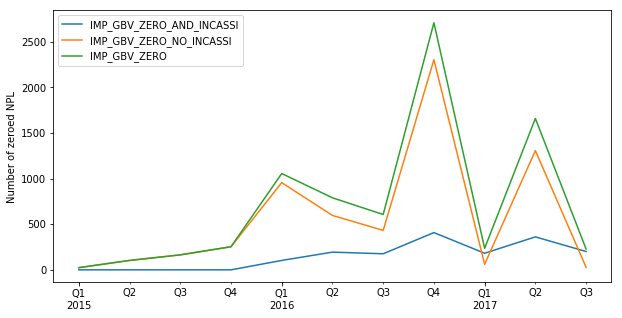

In [30]:
tmp=pd.concat([
    df.loc[(df['IMP_GBV']==0)].groupby(['ID_CUSTOMER']).first().groupby(['NUM_YYYYMM']).size().to_frame('IMP_GBV_ZERO')
    ,df.loc[(df['IMP_GBV']==0)&(df['RECOVERY_RATE_TOTAL']>0)].groupby(['ID_CUSTOMER']).first().groupby(['NUM_YYYYMM']).size().to_frame('IMP_GBV_ZERO_AND_INCASSI')
    ,df.loc[(df['IMP_GBV']==0)&(df['RECOVERY_RATE_TOTAL']==0)].groupby(['ID_CUSTOMER']).first().groupby(['NUM_YYYYMM']).size().to_frame('IMP_GBV_ZERO_NO_INCASSI')
], axis=1)

tmp=tmp.resample('Q').sum()
tmp[['IMP_GBV_ZERO_AND_INCASSI','IMP_GBV_ZERO_NO_INCASSI']].plot.line(figsize=(10,5))
tmp['IMP_GBV_ZERO'].plot(legend=True)
plt.xlabel('')
plt.ylabel('Number of zeroed NPL')
plt.show()

The plot show the number of *Zeroed-NPL* (IMP_GBV == 0) per quarter in the reference period:
* <font color='blue'>**Blue**</font>: IMP_GBV = 0 & IMP_CUSUM_INCASSI > 0 (at least one paiement)
* <font color='orange'>**Orange**</font>: IMP_GBV = 0 & IMP_CUSUM_INCASSI ==0 (no paiment received)
* <font color='green'>**Green**</font>: IMP_GBV = 0

Two considerations should be made:
1. Most of the *Zeroed-NPL* does not have any associated paiement
2. The peaks in the distribution suggest that some actions are taken simultaneously on a big number of NPL, in particular in the last quarter of 2016.

My guess is that these peaks represent action taken by NPL portfolio managers to reduce their NPE as indicated by the ECB.

I have also noticed that most of the *Zeroed-NPL*, once removed from the book, are being reported till the end of the year.

# Make some aggregates

In [31]:
agg = df.groupby(['NUM_YYYYMM']).agg({
    'ID_CUSTOMER': 'size',
    'IMP_GBV' : 'sum',
    'IMP_INCASSI' : 'sum'
}).resample('Q').agg({
    'ID_CUSTOMER': 'last',
    'IMP_GBV' : 'last',
    'IMP_INCASSI' : 'sum'
})

agg['RECOVERY_RATE'] = agg['IMP_INCASSI'] / agg['IMP_GBV']

# Values of debt taken off the book
otb = df.loc[(df['IMP_GBV']==0)].groupby(['ID_CUSTOMER']).first()
otb = otb.groupby(['NUM_YYYYMM'])['MAX_IMP_GBV'].sum().resample('Q').sum()
otb=otb.to_frame('IMP_OTB')

agg=pd.concat([agg,otb], axis=1)

In [32]:
# Quarterly
agg

,ID_CUSTOMER,IMP_GBV,IMP_INCASSI,RECOVERY_RATE,IMP_OTB
NUM_YYYYMM,,,,,
2015-03-31,5320,1.179829e+07,0.00,0.000000,45146.00
2015-06-30,6138,1.674996e+07,0.00,0.000000,185331.41
2015-09-30,10334,4.318618e+07,0.00,0.000000,350613.40
2015-12-31,16137,7.854566e+07,0.00,0.000000,1538736.31
2016-03-31,18851,9.683333e+07,870702.66,0.008992,2756781.35
2016-06-30,20478,1.028665e+08,1440563.02,0.014004,2408989.45
2016-09-30,21595,1.057922e+08,1135903.10,0.010737,1943427.40
2016-12-31,23428,1.061451e+08,968140.13,0.009121,11809575.59
2017-03-31,19304,1.099512e+08,1419641.89,0.012912,1088644.16


In [33]:
# Quarterly
agg.pct_change()

,ID_CUSTOMER,IMP_GBV,IMP_INCASSI,RECOVERY_RATE,IMP_OTB
NUM_YYYYMM,,,,,
2015-03-31,NaN,NaN,NaN,NaN,NaN
2015-06-30,0.153759,0.419694,NaN,NaN,3.105157
2015-09-30,0.683610,1.578285,NaN,NaN,0.891819
2015-12-31,0.561544,0.818769,NaN,NaN,3.388698
2016-03-31,0.168185,0.232828,inf,inf,0.791588
2016-06-30,0.086308,0.062305,0.654483,0.557447,-0.126159
2016-09-30,0.054546,0.028441,-0.211487,-0.233293,-0.193260
2016-12-31,0.084881,0.003336,-0.147691,-0.150525,5.076674
2017-03-31,-0.176029,0.035857,0.466360,0.415600,-0.907817


In [34]:
# yearly
aggy=agg.resample('Y').agg({
    'ID_CUSTOMER': 'last',
    'IMP_GBV' : 'last',
    'IMP_INCASSI' : 'sum',
    'IMP_OTB': 'sum'
})

display(aggy)

,ID_CUSTOMER,IMP_GBV,IMP_INCASSI,IMP_OTB
NUM_YYYYMM,,,,
2015-12-31,16137,7.854566e+07,0.00,2119827.12
2016-12-31,23428,1.061451e+08,4415308.91,18918773.79
2017-12-31,20984,1.138687e+08,5177173.27,9240538.81


In [35]:
aggy.pct_change()

,ID_CUSTOMER,IMP_GBV,IMP_INCASSI,IMP_OTB
NUM_YYYYMM,,,,
2015-12-31,NaN,NaN,NaN,NaN
2016-12-31,0.451819,0.351381,inf,7.924678
2017-12-31,-0.104320,0.072764,0.172551,-0.511568


In [36]:
aggy.divide(aggy['IMP_GBV'], axis=0)[['IMP_INCASSI', 'IMP_OTB']]

,IMP_INCASSI,IMP_OTB
NUM_YYYYMM,,
2015-12-31,0.000000,0.026988
2016-12-31,0.041597,0.178235
2017-12-31,0.045466,0.081151


## Number of NPL per quarter

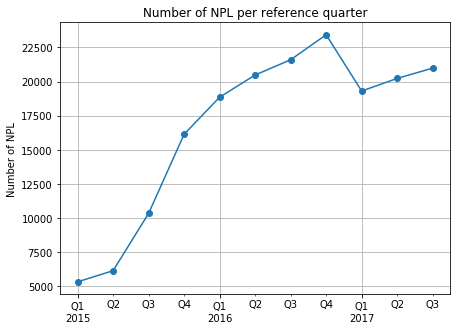

In [37]:
agg['ID_CUSTOMER'].plot(title='Number of NPL per reference quarter', color='C0', marker='o', grid=True, figsize=(7,5))
plt.xlabel('')
plt.ylabel('Number of NPL')
plt.savefig('pictures/num_npl_quarter.png', bbox_inches='tight')
plt.show()

It is important to notice:
* An increase of the number of NPL from the second half of 2015
* Q1-2017 see a 16% reduction of NPL, this drop is related to the NPLs taken off the book on Q4-2016

## Volume of NPL debt per reference quarter

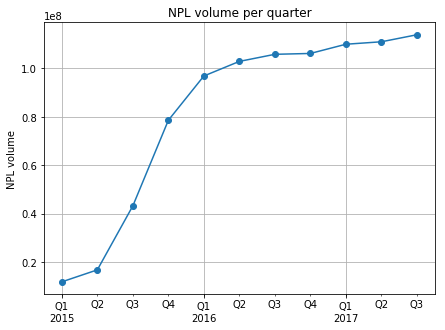

In [38]:
agg['IMP_GBV'].plot(title='NPL volume per quarter', color='C0', marker='o',grid=True, figsize=(7,5))
plt.xlabel('')
plt.ylabel('NPL volume')
plt.savefig('pictures/vol_npl_quarter.png', bbox_inches='tight')
plt.show()

It is important to notice:
* From the Q1-2016 the volume of NPL debt cumulated slowed down;
* Is this the effect of the action taken to reduce the NPE?

## Off-the-book NPL debt volume per reference quarter

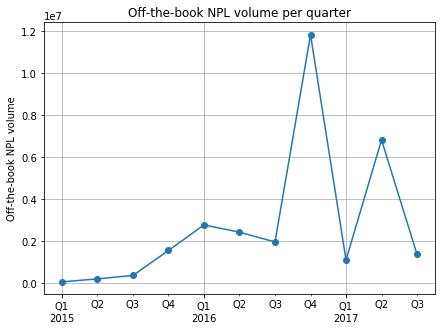

In [39]:
agg['IMP_OTB'].plot(title='Off-the-book NPL volume per quarter', color='C0', marker='o', grid=True, figsize=(7,5))
plt.xlabel('')
plt.ylabel('Off-the-book NPL volume')
plt.savefig('pictures/vol_otb_quarter.png', bbox_inches='tight')
plt.show()

It is important to notice:
* There are two sharp peaks in Q4-2016 and Q2-2017;

This plot corroborate the hypotesis that *Zeroed-NPL* are NPL that get removed from the book to reduce bank's NPE.

## Volume of INCASSI per quarter

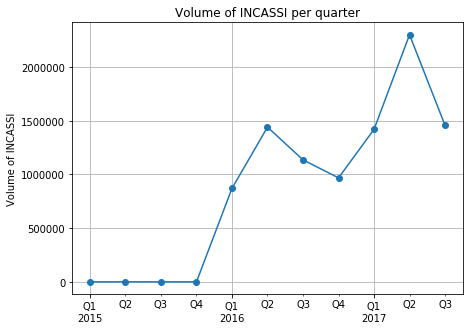

In [40]:
agg['IMP_INCASSI'].plot(title='Volume of INCASSI per quarter', color='C0', marker='o', grid=True, figsize=(7,5))
plt.xlabel('')
plt.ylabel('Volume of INCASSI')
plt.savefig('pictures/vol_incassi_quarter.png', bbox_inches='tight')

plt.show()

It is important to notice:
* The volume of INCASSI increased steadly up to Q2-2016;
* From Q2-2016 to Q4-2017 there is a reduction of INCASSI which coincide with the increase of NPL taken off-the book;
* This suggest that the action to reduce NPE taken between Q1-2016 and Q3-2016 also reduced the recovery rate in the same period;
* On the other hand, a second action in Q2-2017 did not reduce the recovery rate. What has changed?

## Recovery rate per quarter

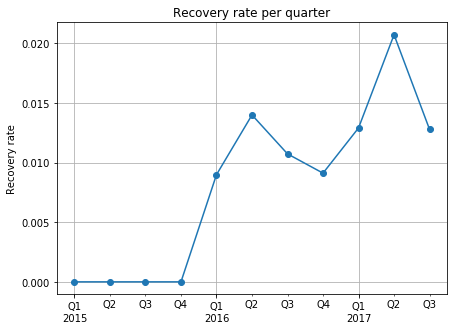

In [41]:
agg['RECOVERY_RATE'].plot(title='Recovery rate per quarter', color='C0', marker='o', grid=True, figsize=(7,5))
plt.xlabel('')
plt.ylabel('Recovery rate')
plt.savefig('pictures/recovery_rate_quarter.png', bbox_inches='tight')
plt.show()

#### It is important to notice:
* The recovery rate increased steadily from Q4-2015;
* The action taken in Q4-2016 to reduce the NPE have also reduced the recovery rate by more than 30%;
* The recovery rate restart growing from Q1-2017;

# NPL age distribution

In [42]:
tmp=df.groupby(['ID_CUSTOMER'])[['NUM_DATA_SOFFERENZA','IMP_GBV','IMP_INCASSI_TOT','NUM_MONTHS_SOFFERENZA']].last()

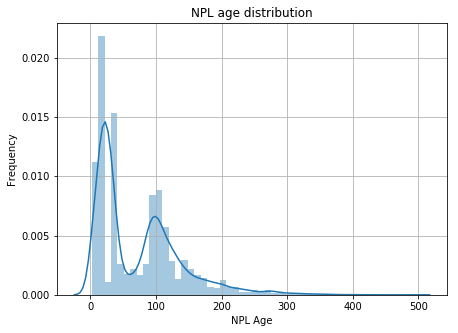

In [43]:
plt.figure(figsize=(7,5))
sns.distplot(tmp['NUM_MONTHS_SOFFERENZA'])
plt.grid(True)
plt.title('NPL age distribution')
plt.xlabel('NPL Age')
plt.ylabel('Frequency')
plt.savefig('pictures/age_npl_distribution.png', bbox_inches='tight')
plt.show()

The NPL age shows a clear bi-modal distribution, i.e. the data contain two populations:
* The first poulation of NPL is repaied within about 15 - 20 months
* The second population of NPL is repaied within about 100 months (~10 year)

The first population it is due to NPL reported within in the period of reference (2015, 2017), while the second population is dominated by old NPL.

Let'us look at the two populations:

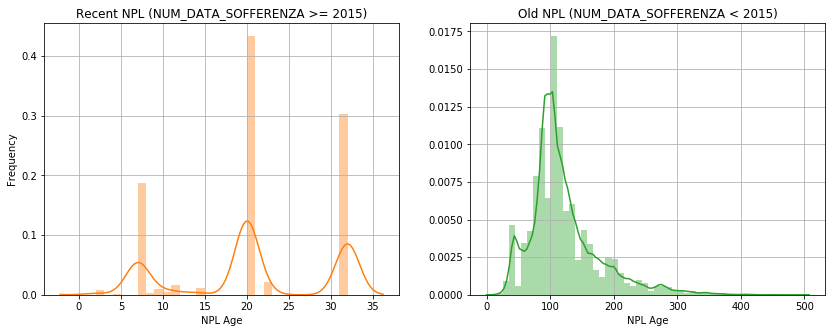

In [44]:
_, ax = plt.subplots(1,2, figsize=(14,5))
ax1=sns.distplot(tmp.loc[(tmp['NUM_DATA_SOFFERENZA'].dt.year>=2015),'NUM_MONTHS_SOFFERENZA'], ax=ax[0], color='C1')
ax1.grid(True)
ax1.set_xlabel('NPL Age')
ax1.set_ylabel('Frequency')
ax1.set_title('Recent NPL (NUM_DATA_SOFFERENZA >= 2015)')

ax2=sns.distplot(tmp.loc[(tmp['NUM_DATA_SOFFERENZA'].dt.year<2015),'NUM_MONTHS_SOFFERENZA'], ax=ax[1], color='C2')
ax2.grid(True)
ax2.set_xlabel('NPL Age')
ax2.set_title('Old NPL (NUM_DATA_SOFFERENZA < 2015)')

plt.show()

It is important to notice: 
* Age for recent NPL is sensible to the length of the reference period;
* The peak at 7, 20 and 33 months clearly represent horizon for NPL being considered from 2017, 2016 and 2015;
* Old NPLs show an average age of about 100 months;

## Overall probability of repaiment
Earlier I have defined the feature 'RECOVERY_RATE_TOTAL' which represent the fraction of NPL being repaied. By definition this feature range from 0 (no recovery at all) to 1 (full repaiement).

The binned distribution of this feature represent the fraction os NPLs for which a certain amount of debt is recovered. This can be interpreted as the overall probability of repaiment, i.e. for each NPL, the probability that a cerain amount could be recovered.

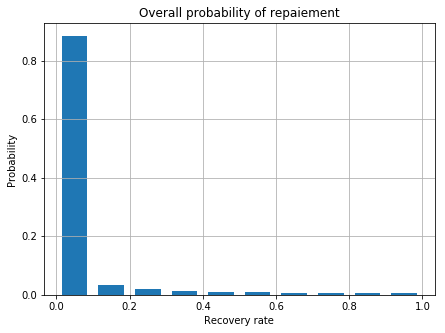

In [45]:
# Let's define the fraction of 
tmp=df.groupby('ID_CUSTOMER').last()
f,b=np.histogram(tmp['RECOVERY_RATE_TOTAL'], range=[0,1], bins=np.arange(0,1.1,0.1))
f = f/sum(f)

w = 0.7 * (b[1] - b[0])
c = (b[:-1] + b[1:]) / 2

plt.figure(figsize=(7,5))
plt.bar(c, f, align='center', width=w)
plt.grid(True)
plt.title('Overall probability of repaiement')
plt.xlabel('Recovery rate')
plt.ylabel('Probability')
plt.show()

In [46]:
print('Prob. of debt repaiement: ')
for (b0,b1),f0 in zip(zip(b, b[1:]),f):
    print(' (%.1f, %.1f): %.2f' % (b0,b1,f0))

Prob. of debt repaiement: 
 (0.0, 0.1): 0.88
 (0.1, 0.2): 0.03
 (0.2, 0.3): 0.02
 (0.3, 0.4): 0.01
 (0.4, 0.5): 0.01
 (0.5, 0.6): 0.01
 (0.6, 0.7): 0.01
 (0.7, 0.8): 0.01
 (0.8, 0.9): 0.01
 (0.9, 1.0): 0.01


The bar plot and the table showed above represent the probability an NPL is repaied by a given amount (in bins of 10%).

From this analysis we can make the following observaitons:
* About 90% of the NPL get repaied for less than 10%;
* About 11 % of the NPL get repaied between the 10% and the 90%;
* About 1% of the NPL get repaid for more than 90%;

# Summary

In this notebook I have focus on the 'PERIMETRO_INIZIALE' file which represent the key dataset for this challenge. 

This dataset contain all the information related to NPL, among which: 
* The debt Gross Book Value;
* Eventual amount paied by the customer;
* The year of first credit distress;

These are the key information to reach the challenge objective to **define a strategy to re-rank NPL customer according to the likelihood to repay** and/or by **suggesting new strategies to maximize the recovery rate**. 

To summarize, In this notebook I have performend the following:
* Cleaned the dataset by removing/replacing null values and rejecting invalid rows;
* Defined some interesiting new features such as:
    * The age of the NPL: 'NUM_DATA_SOFFERENZA';
    * The maximum amount of debt: 'MAX_IMP_GBV';
    * The total NPL recovery rate: 'RECOVERY_RATE_TOTAL' defined as 'IMP_CUSUM_INCASSI' / 'MAX_IMP_GBV';
* Perfomed some analytics to develop intuitions about the data and their meaning:
    * Number of NPL, NPL volume, Total INCASSI, Recovery rate, Off-the-book debt by reference quarter;
    * Number of NPL and NPL volume by first year of credit distress;
    * Overall probability of repaiement;

The key takeaways from this analysis are the following:
1. The historical data of NPL seems to be sensitive to major macro-economic events such as the 2008 financial crisis;
2. The number of NPL and their volume increased steadily up to Q1-2016 when ECB reccomandation to decrease NPE started to be implemented; 
3. Some actions implemented in 2016 removed about 19M€ of debt from the book, corresponding to about 18% of the GBV in the same period. As a results, the number NPL decreased by about 17%, and the amount recovered decreased by 30%;
4. The overall probability of repaiment is low. Historically, about 90% of NPLs are repaied by less than 10% of their GBV;

The resulting dataset is exported to further use in other notebook.

In [47]:
df.to_csv(path.join(DATA_PATH,'PERIMETRO_INIZIALE_PREPROCESS.csv'), index=False)